# Lagrangian Descriptors: Python code

## Functions

In [ ]:
import numpy
import matplotlib.pyplot as plt

### Runge-Kutta 4th Order solver

In [ ]:
def runge45_1D(h,t,p,f,flag_pert,pert_params):
    A2 = 0.2;
    A3 = 0.3;
    A4 = 0.6;
    A5 = 1.0;
    A6 = 0.875;
    B21 = 0.2;
    B31 = 3 / 40;
    B32 = 9 / 40;
    B41 = 0.3;
    B42 = -0.9;
    B43 = 1.2;
    B51 = -11 / 54;
    B52 = 2.5;
    B53 = -70 / 27;
    B54 = 35 / 27;
    B61 = 1631 / 55296;
    B62 = 175 / 512;
    B63 = 575 / 13824;
    B64 = 44275 / 110592;
    B65 = 253 / 4096;
    C1 = 37 / 378;
    C3 = 250 / 621;
    C4 = 125 / 594;
    C6 = 512 / 1771;
    DC1 = C1 - 2825 / 27648; 
    DC3 = C3 - 18575 / 48384; 
    DC4 = C4 - 13525 / 55296; 
    DC5 = -277 / 14336;
    DC6 = C6 - 0.25;
    
    ak1 = f(t,p,flag_pert,pert_params);
    p_temp = p + B21 * h * ak1;
        
    ak2 = f(t + A2 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B31 * ak1 + B32 * ak2);
    
    ak3 = f(t + A3 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B41 * ak1 + B42 * ak2 + B43 * ak3);
    
    ak4 = f(t + A4 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B51 * ak1 + B52 * ak2 + B53 * ak3 + B54 * ak4);
    
    ak5 = f(t + A5 * h,p_temp,flag_pert,pert_params);
    p_temp = p + h * (B61 * ak1 + B62 * ak2 + B63 * ak3 + B64 * ak4 + B65 * ak5);
    
    ak6 = f(t + A6 * h,p_temp,flag_pert,pert_params);
    
    p_new = p + h * (C1 * ak1 + C3 * ak3 + C4 * ak4 + C6 * ak6);
    p_err = h * (DC1 * ak1 + DC3 * ak3 + DC4 * ak4 + DC5 * ak5 + DC6 * ak6);
    
    return p_new, p_err

### Vector fields for Dynamical System (for benchmark examples)

### Forcing

CHANGES: Redefined `pert` to correct form.

In [ ]:
# t : single time value
# p : all points in mesh

def forcing(t,p,flag_pert,pert_params):
    x = p[:,0];

    pert = numpy.zeros((p.shape[0],1));   
    
    A = pert_params[0];  # Amplitude of perturbation
    freq = pert_params[1];  # Frequency of perturbation
    
    if flag_pert == 1:
        pert = A * numpy.sin(freq*t);
    elif flag_pert == 2:
        pert = A * numpy.sech(t) * numpy.sin(freq*t);
    else:
        pert = pert;

    return pert

### Hamilton Centre

In [ ]:

def HamCenter_1D(t,p,flag_pert,pert_params):
   
    vel = numpy.zeros((p.shape[0],2));
       
    pert = forcing(t,p,flag_pert,pert_params);
    
    # Hamiltonian Model Parameter
    omega = 1;
    
    x = p[:,0];
    y = p[:,1];
       
    vel[:,0] = omega * y;
    vel[:,1] = - omega * x + pert;

    return vel

### Hamilton Saddle

In [ ]:

def HamSaddle_1D(t,p,flag_pert,pert_params):
   
    vel = numpy.zeros((p.shape[0],2));
    
    pert = forcing(t,p,flag_pert,pert_params);
       
    # Hamiltonian Model Parameter
    lamda = 1;
    
    x = p[:,0];
    y = p[:,1];
    
    vel[:,0] = lamda * y;
    vel[:,1] = lamda * x + pert;
    
    return vel

__TO-DO__

Turn the matrix of vel (Nx2) into a single array (2N). Then, change output.

### Hamilton Duffing

In [ ]:

def HamDuffing_1D(t,p,flag_pert,pert_params):
    
    vel = numpy.zeros((p.shape[0],2));
      
    pert = forcing(t,p,flag_pert,pert_params);
    
    x = p[:,0];
    y = p[:,1];
       
    vel[:,0] = y;
    vel[:,1] = x - x**3 + pert;

    return vel

#### Function to accumulate LD values for every timestep

In [ ]:
def accum_LDs(LD_val,pts,pts_new,flag_m,p,dt):
    if flag_m: # p-norm LDs
        accum = LD_val + ((abs(pts_new[:,0] - pts[:,0]))**p + (abs(pts_new[:,1] - pts[:,1]))**p) * dt ** (1 - p);
    else:  # arclength LDs
        accum = LD_val + sqrt((pts_new[:,0] - pts_new[:,0])**2 + (pts_new[:,1] - pts[:,1])**2);
    return accum

### Compute all LDs by generating a trajectory in phase space

In [ ]:

def LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,vf_name,flag_pert,pert_params):
    # @author: V. J. García-Garrido                                                                           
    # Date: 24-04-2020
    
    # %%%%%%%%%%%%%%5%%%%%%%%%%%%%%%%%%%%
    #                                  FUNCTION PARAMETERS                                                 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # t0                  = Initial Time
    # flag_m          = Flag that determines the type of LD calculated
    #                         0 (arclength) // 1 (p-norm)
    # p_val            = Exponent for the p-norm LD
    # dt                  = Integration Time Step
    # tau                = Integration time (evolve trajectories in [t0 - tau , t0 + tau])
    # xi , xf            = Initial and final points of the mesh in the x-direction 
    # nx                 = Mumber of gridpoints in the x-direction
    # yi , yf            = Initial and final points of the mesh in the y-direction 
    # ny                 = Mumber of gridpoints in the y-direction
    # vf_name       = Name of the vector field function for the dynamical system
    # flag_pert      = Flag that indicates if the vector field is perturbed
    #                         0 (No Perturbation) // 1 (Time Periodic) // 2 (Aperiodic)
    # pert_params = Array of parameters for the perturbation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    # Function defining the vector field of the Dynamical System
    f = vf_name; 
    
    # Create mesh for the computaion of Lagrangian Descriptors
    mesh = numpy.zeros((nx * ny,2)); 
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);    
    [X,Y] = numpy.meshgrid(xp,yp);  
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    
    # Forward integration
    ld_fw = numpy.zeros(nx * ny);  # Array to store forward LDs
    pts = mesh;
    
    for t_fwd in numpy.arange(t0, t0 + tau - dt, dt):      
        pts_new = runge45_1D(dt,t_fwd,pts,f,flag_pert,pert_params)[0];         
        ld_fw = accum_LDs(ld_fw,pts,pts_new,flag_m,p_val,dt);
        pts = pts_new;
        
    # Backward integration
    ld_bw = numpy.zeros(nx * ny);  # Array to store backward LDs
    pts = mesh;
    
    for t_bw in numpy.arange(t0, t0 - tau + dt, -dt):
        pts_new = runge45_1D(-dt,t_bw,pts,f,flag_pert,pert_params)[0];          
        ld_bw = accum_LDs(ld_bw,pts,pts_new,flag_m,p_val,dt);
        pts = pts_new;
    
    return ld_fw, ld_bw

TEST

In [ ]:
# Simulation Parameters (LD method setup)
t0 = 0;
tau = 12;
flag_m = 1;
p_val = 1/2;
dt = 0.1;

# Mesh to compute LDs
xi = -1.6;
xf = 1.6;
nx = 300;
yi = -1;
yf = 1;
ny = 300;

# Time Dependent Perurbation
flag_pert = 1;
pert_params = [0.15, 0.5];

In [ ]:
f = HamCenter_1D 

# Create mesh for the computaion of Lagrangian Descriptors
mesh = numpy.zeros((nx * ny,2)); 
xp = numpy.linspace(xi,xf,nx);
yp = numpy.linspace(yi,yf,ny);    
[X,Y] = numpy.meshgrid(xp,yp);  
mesh[:,0] = X.T.reshape(-1)
mesh[:,1] = Y.T.reshape(-1)

# Forward integration
ld_fw = numpy.zeros(nx * ny);  # Array to store forward LDs
pts = mesh;

In [ ]:
for t_fwd in numpy.arange(t0, t0 + tau - dt, dt):      
    pts_new = runge45_1D(dt,t_fwd,pts,f,flag_pert,pert_params)[0];         
    ld_fw = accum_LDs(ld_fw,pts,pts_new,flag_m,p_val,dt);
    pts = pts_new;

In [ ]:
pts.shape, type(pts)

### Plot all LDs from data

In [ ]:
def draw_LDs_1D(t0,tau,flag_m,p,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw):
    
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);
    X,Y = numpy.meshgrid(xp,yp)

    if flag_m:
        str_meth = ['p-norm (p=',str(p),')--'];
    else:
        str_meth = ['arclength --'];
    
    if flag_type == 1:
        LD = ld_fw.reshape(nx,ny).T;
        string_title = ['Forward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    elif flag_type == 2:
        LD = ld_bw.reshape(nx,ny).T;
        string_title = ['Backward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    else:
        LD = (ld_fw + ld_bw).reshape(nx,ny).T;
        string_title = ['LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    
    LD = LD / LD.max();  # Scale LD output
    
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    scatter = plt.scatter(X,Y,c=LD,cmap='bone')

    # Customise appearance
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('q', fontsize=18)
    ax.set_ylabel('p', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter)

    plt.show()

## Benchmark examples

In [ ]:
%matplotlib inline

# Simulation Parameters (LD method setup)
t0 = 0;
tau = 12;
flag_m = 1;
p_val = 1/2;
dt = 0.1;

# Mesh to compute LDs
xi = -1.6;
xf = 1.6;
nx = 300;
yi = -1;
yf = 1;
ny = 300;

# Time Dependent Perurbation
flag_pert = 1;
pert_params = [0.15, 0.5];

### Hamilton Centre

In [ ]:
# vector Field for the Dynamical System 
ds = HamCenter_1D;
# ds = HamDuffing_1D;
# ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

### Hamilton Saddle

In [ ]:
# vector Field for the Dynamical System 
# ds = HamCenter_1D;
# ds = HamDuffing_1D;
ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

### Hamilton Duffing

In [ ]:
# vector Field for the Dynamical System 
# ds = HamCenter_1D;
ds = HamDuffing_1D;
# ds = HamSaddle_1D;

# Computation of LDs
ld_fw,ld_bw = LDs_1D(t0,tau,flag_m,p_val,dt,xi,xf,nx,yi,yf,ny,ds,flag_pert,pert_params);

# Draw Forward LDs
flag_type = 1;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw Bacward LDs
flag_type = 2;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# % Draw LDs
flag_type = 3;
draw_LDs_1D(t0,tau,flag_m,p_val,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw);

# Version: Python-built-in integrator

## Functions

DOCUMENTATION

https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

In [1]:
import numpy
import matplotlib.pyplot as plt

Redefined accumulator function

### Vector fields

In [2]:
def HamCenter_1D(t, points_flat):
    # Hamiltonian Model Parameter
    omega = 1;
    x, y = points_flat.reshape((nx*ny,2)).T
    v = numpy.array([ omega * y, - omega * x]).T
    return v.reshape(-1)

In [3]:
def HamSaddle_1D(t,points_flat):
    # Hamiltonian Model Parameter
    lamda = 1;
    x, y = points_flat.reshape((nx*ny,2)).T
    v = numpy.array([ lamda * y, lamda * x]).T
    return v.reshape(-1)

In [4]:
def forcing(t, points_flat, flag_pert, pert_params):
    x, y = points_flat.reshape((nx*ny,2)).T
    pert = numpy.zeros((len(x),1))
    # Perturbation parameters
    A = pert_params[0];  # Amplitude
    freq = pert_params[1];  # Frequency
    
    if flag_pert == 1:
        pert = A * numpy.sin(freq*t)
    elif flag_pert == 2:
        pert = A * numpy.sech(t) * numpy.sin(freq*t)
    else:
        pert = pert
    return pert

In [5]:
def HamDuffing_1D(t,points_flat):
    x, y = points_flat.reshape((nx*ny,2)).T
    perturbation = forcing(t, points_flat, flag_pert, pert_params)
    v = numpy.array([y, x - x**3 + perturbation]).T
    return v.reshape(-1)

Example with a single inital condition

In [6]:
def extract_y_final(solution_object):
    y_final = solution_object.y.T[-1]
    return y_final

### LD accumulator

In [7]:
def accum_LDs(LD_val, points_initial, points_next, flag_m, p, dt):
    if flag_m: # p-norm LDs
        accum = LD_val + ((abs(points_next[:,0] - points_initial[:,0]))**p + (abs(points_next[:,1] - points_initial[:,1]))**p) * dt ** (1 - p);
    else:  # arclength LDs
        accum = LD_val + sqrt((points_next[:,0] - points_next[:,0])**2 + (points_next[:,1] - points_initial[:,1])**2);
    return accum

### LD calculator

In [8]:
def lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field):
    # Create mesh for the computaion of Lagrangian Descriptors
    mesh = numpy.zeros((nx * ny,2)); 
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);    
    [X,Y] = numpy.meshgrid(xp,yp);  
    mesh[:,0] = X.T.reshape(-1)
    mesh[:,1] = Y.T.reshape(-1)
    
    f = vector_field
    
    # Forward integration
    ld_forward = numpy.zeros(nx*ny)  # Array to store forward LDs
    points_initial = mesh

    for t in numpy.arange(t0, t0 + tau - dt, dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t+dt)
        y0 = points_initial.reshape(-1)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0)
        points_final = extract_y_final(solution_object).reshape((nx*ny, 2))
        ###################################
        # Compute LD
        ld_forward = accum_LDs(ld_forward, points_initial, points_final, True, p_value, dt)
        ###################################
        # For next iteration
        points_initial = points_final

    # Backward integration
    ld_backward = numpy.zeros(nx*ny);  # Array to store backward LDs
    points_initial = mesh
    
    for t in numpy.arange(t0, t0 - tau + dt, -dt):
        ###################################
        # Inputs for integrator
        t_span = (t, t-dt)
        y0 = points_initial.reshape(-1)
        ###################################
        # Outputs from integration
        solution_object = integrator(f, t_span, y0)
        points_final = extract_y_final(solution_object).reshape((nx*ny, 2))
        ###################################
        # Compute LD
        ld_backward = accum_LDs(ld_backward, points_initial, points_final, True, p_value, dt)
        ###################################
        # For next iteration
        points_initial = points_final
    
    return ld_backward, ld_forward

### LD plotter

In [9]:
def draw_LDs_1D(t0,tau,flag_m,p,xi,xf,nx,yi,yf,ny,flag_type,ld_fw,ld_bw):
    xp = numpy.linspace(xi,xf,nx);
    yp = numpy.linspace(yi,yf,ny);
    X,Y = numpy.meshgrid(xp,yp)

    if flag_m:
        str_meth = ['p-norm (p=',str(p),')--'];
    else:
        str_meth = ['arclength --'];
    
    if flag_type == 1:
        LD = ld_fw.reshape(nx,ny).T;
        string_title = ['Forward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    elif flag_type == 2:
        LD = ld_bw.reshape(nx,ny).T;
        string_title = ['Backward LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    else:
        LD = (ld_fw + ld_bw).reshape(nx,ny).T;
        string_title = ['LDs '] + str_meth + ['(','$\\tau=$ ',str(tau),' , ','$t_0=$',str(t0),')'];
        string_title = ' '.join(string_title)
    
    LD = LD / LD.max();  # Scale LD output
    
    # Plot LDs
    fig,ax = plt.subplots(1,1,dpi=100)
    scatter = plt.scatter(X,Y,c=LD,cmap='bone')

    # Customise appearance
    ax.set_title(string_title, fontsize=12)
    ax.set_xlabel('q', fontsize=18)
    ax.set_ylabel('p', fontsize=18)
    ax.set_aspect('auto')

    fig.colorbar(scatter)

    plt.show()

## Benchmark examples

#### STEP 1: INPUT PARAMETERS

In [10]:
###################################
#
# Integration parameters
#
###################################
t0 = 0
tau = 12
dt = 0.1
###################################
#
# Lagrangian descriptor parameters
#
###################################
p_value = 1/2
flag_m = True
###################################
#
# Mesh parameters
#
###################################
xi,xf = [-1.6, 1.6]
yi,yf = [-1, 1]
nx, ny = [300, 300]
###################################
# Time Dependent Perurbation (for Hamilton Duffing)
flag_pert = 1;
pert_params = [0.15, 0.5];
###################################
#
# Create mesh
#
###################################
mesh = numpy.zeros((nx * ny,2)) # Mesh to accumulate ?????
xp = numpy.linspace(xi,xf,nx)
yp = numpy.linspace(yi,yf,ny)    
[X,Y] = numpy.meshgrid(xp,yp)  # Grid in pahse-space
mesh[:,0] = X.T.reshape(-1)
mesh[:,1] = Y.T.reshape(-1)

#### STEP 2: SET INTEGRATOR

In [11]:
import scipy.integrate
integrator = scipy.integrate.solve_ivp # RK45 (default)

#### STEP 3: DEFINE VECTOR FIELD, COMPUTE, AND VISUALIZE

### Hamilton Centre

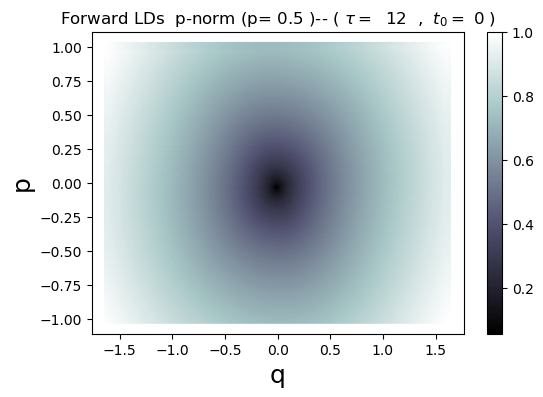

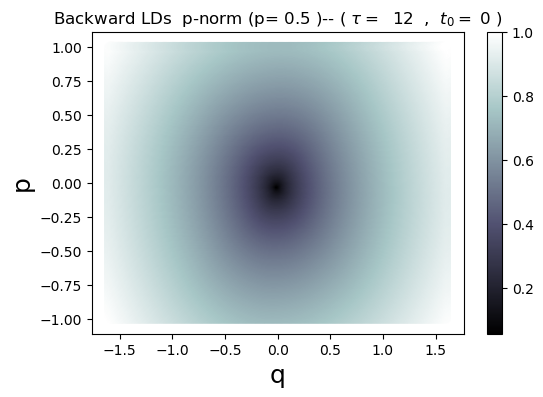

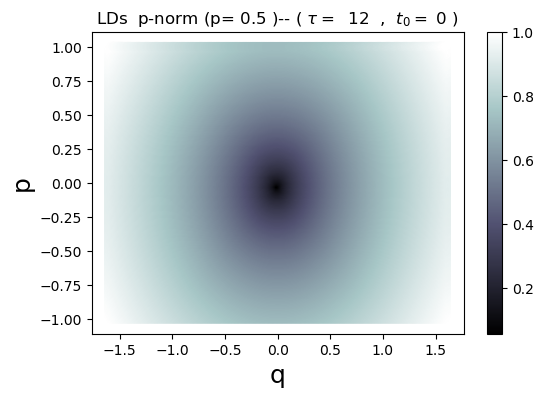

In [12]:
vector_field = HamCenter_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)

### Hamilton Saddle

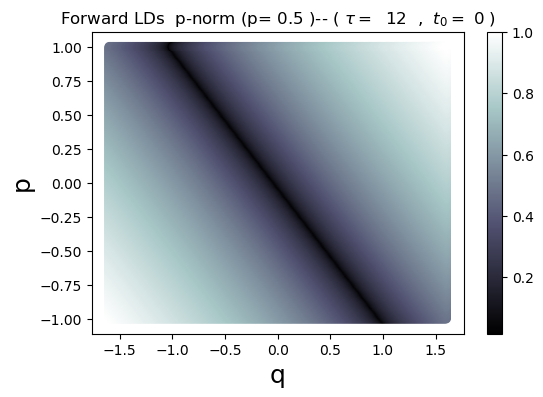

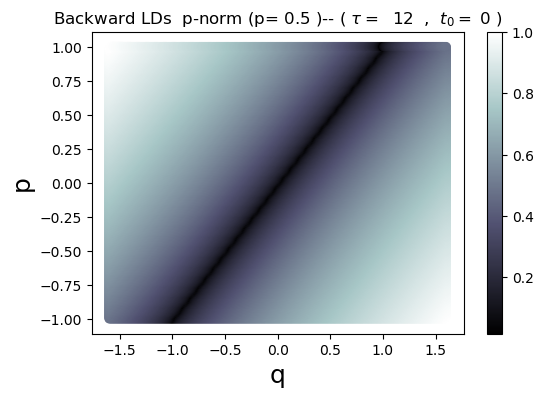

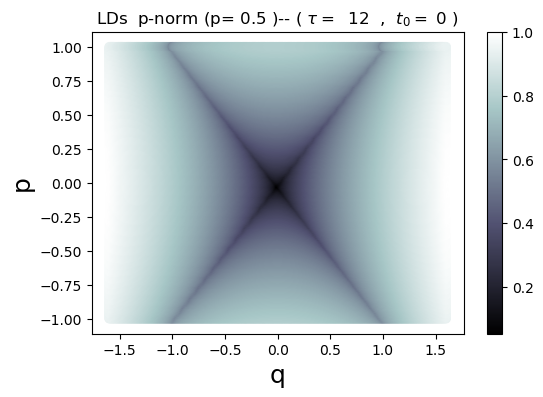

In [13]:
vector_field = HamSaddle_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)

### Hamilton Duffing (with forcing)

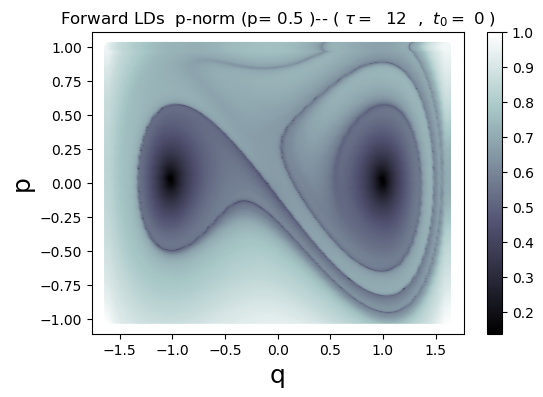

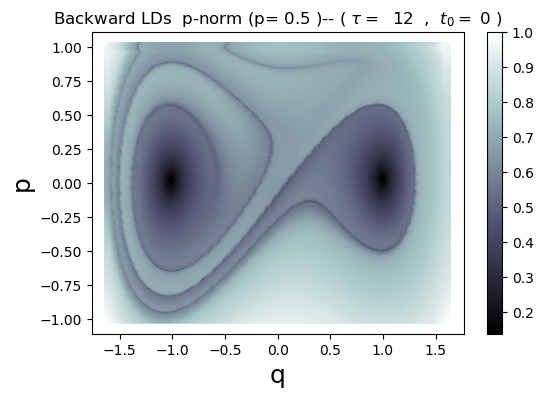

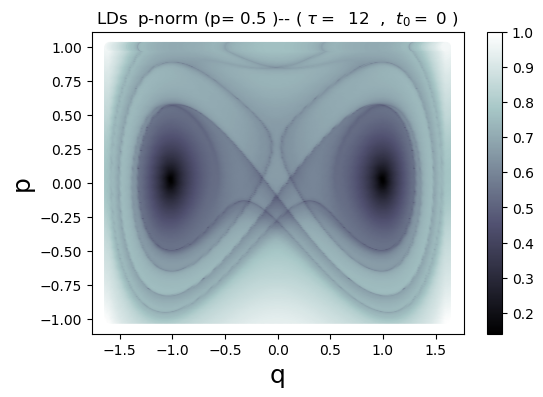

In [14]:
vector_field = HamDuffing_1D
f = vector_field

# Computation of LDs
ld_backward, ld_forward = lagrangian_descriptors(t0,tau,flag_m,p_value,dt,xi,xf,nx,yi,yf,ny,vector_field)

for flag_type in [1,2,3]:
    draw_LDs_1D(t0,tau,flag_m,p_value,xi,xf,nx,yi,yf,ny,flag_type,ld_forward,ld_backward)